<a href="https://colab.research.google.com/github/reshalfahsi/neuralnetwork/blob/main/notebook/NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Install Package**

In [ ]:
!git clone https://github.com/reshalfahsi/neuralnetwork
%cd neuralnetwork
!pip install .

## **Hyperparameters**

In [2]:
NUM_EPOCHS = 100
BATCH_SIZE = 16
lr = 1e-4

## **Dataset Preparation**

This tutorial will use a toy dataset from [MedMNIST](https://medmnist.com/). We use PneumoniaMNIST, which contains 2D X-ray image-label pairs for distinguishing between Pneumonia-infected and healthy lungs. The pneumonia-infected lung is denoted by the label `1` whilst the healthy lung is labeled as `0`.

In [3]:
from neuralnetwork.ds.medmnist import PneumoniaMNIST
from neuralnetwork import ds
import numpy as np


train_dataset = PneumoniaMNIST(split='train', download=True)
test_dataset = PneumoniaMNIST(split='test', download=True)

print("Train Dataset:", len(train_dataset))
print("Test Dataset", len(test_dataset))

  0%|          | 0/4170669 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Train Dataset: 4708
Test Dataset 624


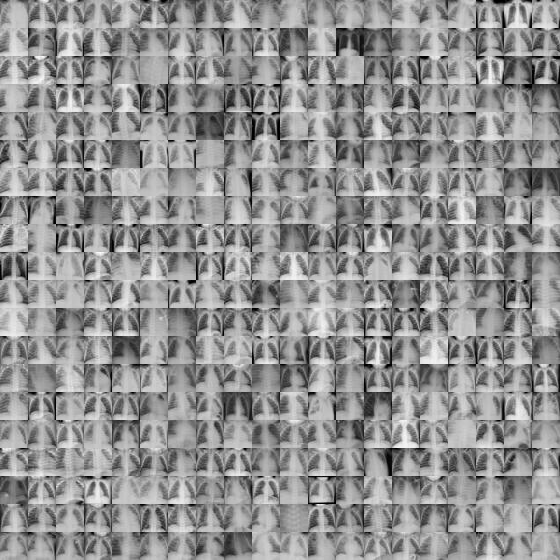

In [4]:
train_dataset.montage(length=20)

## **Neural Network**

The artificial neural network is a bio-inspired machine learning method that models neuronal signal propagation by matrix multiplication. Here we have two kinds of neuronal signal propagation: forward propagation and backward propagation. In forward propagation, the neuron actively conveys information from the "receptor" (or input) to the "central nervous system" (or output). Backward propagation or backpropagation, in short, is utilized in the training or learning process. In the learning process, the neural network transmits error gradients from the "central nervous system" to the "receptor". For further knowledge about the learning process, read more: [Calculus on Computational Graphs: Backpropagation](https://colah.github.io/posts/2015-08-Backprop/) and [Backpropagation for a Linear Layer
](https://web.eecs.umich.edu/~justincj/teaching/eecs442/notes/linear-backprop.html).

In [5]:
import neuralnetwork.nn as nn


class NeuralNetwork(nn.Module):
    def __init__(self, **kwargs):
        super(NeuralNetwork, self).__init__(**kwargs)
        self.linear0 = nn.Linear(784, 200, **kwargs)
        self.linear1 = nn.Linear(200, 200, **kwargs)
        self.linear2 = nn.Linear(200, 1, **kwargs)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        self.out0 = self.linear0(x)
        self.out1 = self.sigmoid(self.out0)
        self.out2 = self.linear1(self.out1)
        self.out3 = self.sigmoid(self.out2)
        self.out4 = self.linear2(self.out3)
        self.out5 = self.sigmoid(self.out4)

        return self.out5
    
    def backward(self, lr, criterion):
                                                               # Computational Graph
                                                               #
        self.dx0 = criterion.grad()                            # loss_grad(pred, y)
                                                               #        |
        self.dx1 = self.sigmoid.grad(self.out4)                # sigmoid_grad(pred)
                                                               #        |
                                                               #        +
                                                               #       / \
                                                               #      |   |
                                                               #  b_grad  *
                                                               #         / \
                                                               #        |   |
        self.dx2 = self.linear2.grad(self.dx1* self.dx0)       #   A_grad   x_grad
                                                               #          .
        self.dx3 = self.sigmoid.grad(self.out2)                #          .
        self.dx4 = self.linear1.grad(self.dx3 * self.dx2)      #          .

        self.dx5 = self.sigmoid.grad(self.out0)
        self.dx6 = self.linear0.grad(self.dx5 * self.dx4)

        self.linear0.update(lr)
        self.linear1.update(lr)
        self.linear2.update(lr)

## **Training**

In [6]:
def accuracy(model, X, Y):
    pred = model(X)
    pred = pred > 0.5
    acc = np.sum(pred == Y)
    acc = acc / Y.shape[0]
    return acc

In [7]:
train_loader = ds.get_loader(dataset=train_dataset, batch_size=BATCH_SIZE)
test_loader = ds.get_loader(dataset=test_dataset, batch_size=1)

criterion = nn.MSELoss()
model = NeuralNetwork()

In [8]:
for epoch in range(NUM_EPOCHS):
    loss = list()
    acc = list()
    for idx, pack in enumerate(train_loader):
        x, y = pack
        bs = x.shape[0]
        L = x.shape[1] * x.shape[2]
        x = x.reshape(bs, L) / 255.0
        pred = model(x)
        loss.append(criterion(pred, y))
        model.backward(lr, criterion)
        acc.append(accuracy(model, x, y))
        print(
            "{}/{} - The training loss at {}th epoch : {}  Training Accuracy:{}".format(
                idx * BATCH_SIZE,
                len(train_dataset),
                epoch,
                np.array(loss).mean(),
                np.array(acc).mean(),
            ),
        )
        if idx > int(len(train_dataset) / BATCH_SIZE):
            break

    if np.array(acc).mean() > 0.9:
        break
    print("-----------------------------------------------------------")

print("Training finished in {} epochs".format(epoch))

Streaming output truncated to the last 5000 lines.
784/4708 - The training loss at 13th epoch : 0.09465742630504774  Training Accuracy:0.865
800/4708 - The training loss at 13th epoch : 0.09605233373861452  Training Accuracy:0.8639705882352942
816/4708 - The training loss at 13th epoch : 0.09607548145248895  Training Accuracy:0.8653846153846154
832/4708 - The training loss at 13th epoch : 0.09677517103412456  Training Accuracy:0.8643867924528302
848/4708 - The training loss at 13th epoch : 0.09634390916015674  Training Accuracy:0.8634259259259259
864/4708 - The training loss at 13th epoch : 0.09627401465066089  Training Accuracy:0.8636363636363636
880/4708 - The training loss at 13th epoch : 0.09582411805334123  Training Accuracy:0.8649553571428571
896/4708 - The training loss at 13th epoch : 0.09552779241762925  Training Accuracy:0.8640350877192983
912/4708 - The training loss at 13th epoch : 0.09715207786021243  Training Accuracy:0.8620689655172413
928/4708 - The training loss at 13t

## **Testing**

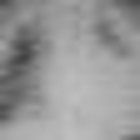

Prediction: Pneumonia
Ground Truth: Pneumonia


In [9]:
import random
from IPython.display import display

index = random.randint(0, len(test_dataset))

x, y = test_dataset[index]
display(x.resize((140, 140)))
x = np.array(x)
L = x.shape[0] * x.shape[1]
x = x.reshape(1, L)/255.
pred = model(x)

pred = pred.squeeze(0)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
print("Prediction: Pneumonia" if pred[0] else "Prediction: Healthy")
print("Ground Truth: Pneumonia" if y[0] else "Ground Truth: Healthy")